https://www.ncbi.nlm.nih.gov/gdv/?org=homo-sapiens

Chromosome: 7

Gene: TAS2R38

SNP: rs713598

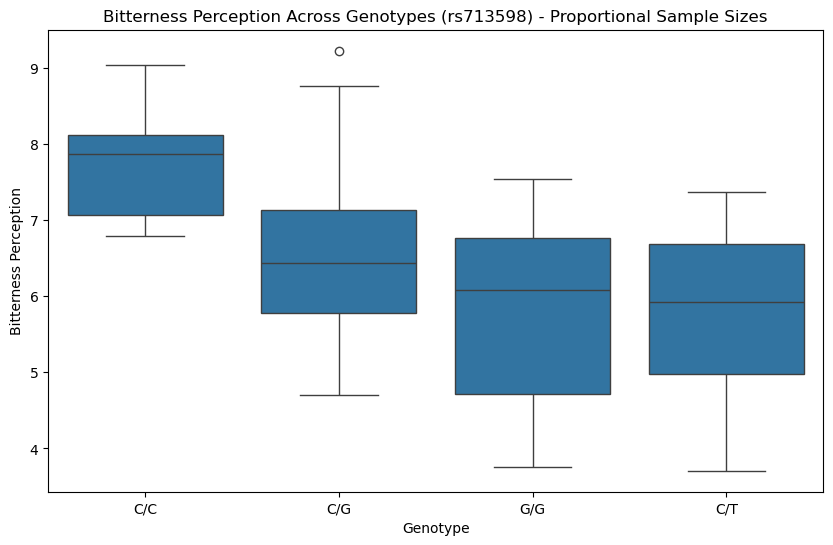

In [66]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Step 1: Define the total sample size and proportions
total_sample_size = 50  # Total sample size
proportions = [0.20, 0.50, 0.23, 0.07]  # Proportions for C/C, C/G, G/G, C/T
genotypes = ['C/C', 'C/G', 'G/G', 'C/T']  # Genotype labels

# Number of genotypes (needed for degrees of freedom in LSD calculation)
num_genotypes = len(genotypes)

# Step 2: Calculate the sample size for each genotype based on proportions
sample_sizes = [int(total_sample_size * prop) for prop in proportions]

# Ensure the total sample size matches
sample_sizes[-1] = total_sample_size - sum(sample_sizes[:-1])  # Adjust the last sample size to match total

# Step 3: Generate the dataset with the specified proportions for each genotype
np.random.seed(42)  # For reproducibility

# Generate the bitterness scores for each genotype based on the calculated sample sizes
bitterness_CC = np.random.normal(7.3, 1.1, sample_sizes[0])  # C/C (high sensitivity)
bitterness_CG = np.random.normal(7.0, 1.2, sample_sizes[1])  # C/G (moderate sensitivity)
bitterness_GG = np.random.normal(6.5, 1.4, sample_sizes[2])  # G/G (lower sensitivity)
bitterness_CT = np.random.normal(6.0, 1.3, sample_sizes[3])  # C/T (new genotype)

# Combine the genotypes and bitterness scores
genotype_samples = ['C/C']*sample_sizes[0] + ['C/G']*sample_sizes[1] + ['G/G']*sample_sizes[2] + ['C/T']*sample_sizes[3]
bitterness_samples = np.concatenate([bitterness_CC, bitterness_CG, bitterness_GG, bitterness_CT])

# Create a DataFrame
df_proportioned = pd.DataFrame({
    'Genotype': genotype_samples,
    'Bitterness Perception': bitterness_samples
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Genotype', y='Bitterness Perception', data=df_proportioned)
plt.title('Bitterness Perception Across Genotypes (rs713598) - Proportional Sample Sizes')
plt.xlabel('Genotype')
plt.ylabel('Bitterness Perception')
plt.show()

F-statistic: 6.75
P-value: 0.0007
Reject the null hypothesis: There is a significant difference in bitterness perception across the genotypes.
LSD (Least Significant Difference) Value: 0.9677
Comparison: C/C vs C/G, Mean Difference: 1.2308, p-value: 0.0029, Bonferroni Adjusted p-value: 0.0177, LSD Value: 0.9677
  95% CI for the difference: [0.2630, 2.1985]
  -> Significant difference based on p-value
  -> Significant difference based on LSD
  -> Significant difference after Bonferroni correction

Comparison: C/C vs G/G, Mean Difference: 2.0321, p-value: 0.0003, Bonferroni Adjusted p-value: 0.0015, LSD Value: 0.9677
  95% CI for the difference: [1.0644, 2.9998]
  -> Significant difference based on p-value
  -> Significant difference based on LSD
  -> Significant difference after Bonferroni correction

Comparison: C/C vs C/T, Mean Difference: 2.0603, p-value: 0.0060, Bonferroni Adjusted p-value: 0.0358, LSD Value: 0.9677
  95% CI for the difference: [1.0926, 3.0281]
  -> Significant diff

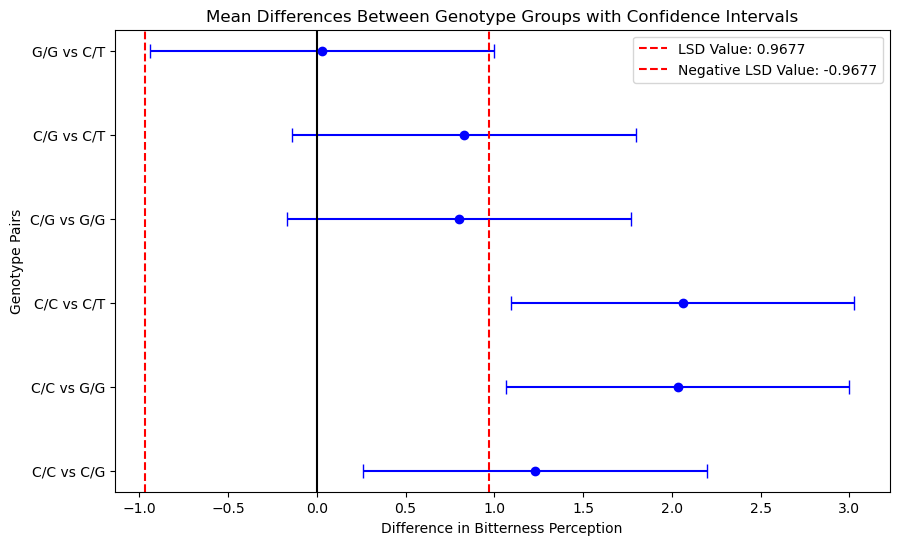

In [75]:
# Step 4: Perform the ANOVA test
anova_result = stats.f_oneway(
    df_proportioned[df_proportioned['Genotype'] == 'C/C']['Bitterness Perception'],
    df_proportioned[df_proportioned['Genotype'] == 'C/G']['Bitterness Perception'],
    df_proportioned[df_proportioned['Genotype'] == 'G/G']['Bitterness Perception'],
    df_proportioned[df_proportioned['Genotype'] == 'C/T']['Bitterness Perception']
)

# Step 5: Output the F-statistic and p-value
print(f'F-statistic: {anova_result.statistic:.2f}')
print(f'P-value: {anova_result.pvalue:.4f}')

# Step 6: Decision based on the p-value
if anova_result.pvalue < 0.05:
    print("Reject the null hypothesis: There is a significant difference in bitterness perception across the genotypes.")
else:
    print("Fail to reject the null hypothesis: No significant difference in bitterness perception.")

# Step 7: Post-hoc Pairwise Comparisons using LSD Test (Least Significant Difference)
# Compute the means and standard errors for each group
means = df_proportioned.groupby('Genotype')['Bitterness Perception'].mean()
sems = df_proportioned.groupby('Genotype')['Bitterness Perception'].sem()

# Step 8: Compute the Mean Squared Error (MSE) based on within-group variances
# MSE is the pooled variance across the groups
within_group_variances = df_proportioned.groupby('Genotype')['Bitterness Perception'].var()
mse = within_group_variances.mean()  # Pooled variance for all groups

# Step 9: Calculate the LSD value (using the formula: LSD = t_critical * sqrt(2 * MSE / n))
t_critical = stats.t.ppf(1 - 0.025, df=(total_sample_size - num_genotypes))  # Degrees of freedom = total samples - num genotypes
lsd_value = t_critical * np.sqrt((2 * mse )/ (total_sample_size / num_genotypes))

# Step 10: Print the LSD value
print(f"LSD (Least Significant Difference) Value: {lsd_value:.4f}")

# Step 11: Perform pairwise comparisons using t-test
genotype_combinations = list(combinations(df_proportioned['Genotype'].unique(), 2))  # All pairs of genotypes
p_values = []

# Calculate p-values from pairwise comparisons
for genotype1, genotype2 in genotype_combinations:
    group1 = df_proportioned[df_proportioned['Genotype'] == genotype1]['Bitterness Perception']
    group2 = df_proportioned[df_proportioned['Genotype'] == genotype2]['Bitterness Perception']
    t_stat, p_val = stats.ttest_ind(group1, group2)
    p_values.append((genotype1, genotype2, p_val))

# Step 12: Calculate the 95% Confidence Intervals for the differences in means
ci_differences = {}

for genotype1, genotype2 in genotype_combinations:
    # Calculate the difference in means
    mean_diff = means[genotype1] - means[genotype2]
    
    # Calculate the standard error for the difference
    sem_diff = np.sqrt(sems[genotype1]**2 + sems[genotype2]**2)
    
    # Calculate the 95% confidence interval for the difference in means
    ci_lower = mean_diff - lsd_value
    ci_upper = mean_diff + lsd_value
    
    ci_differences[(genotype1, genotype2)] = (mean_diff, ci_lower, ci_upper)

# Step 13: Apply Bonferroni correction
alpha = 0.05  # Original significance level
num_comparisons = len(p_values)  # Number of pairwise comparisons
bonferroni_alpha = alpha / num_comparisons  # Adjusted significance level

# Step 14: Print pairwise differences, Bonferroni-adjusted p-values, and compare LSD and p-values
for (genotype1, genotype2, p_val) in p_values:
    mean_diff = means[genotype1] - means[genotype2]  # Calculate the difference in means
    adjusted_p_val = p_val * num_comparisons  # Bonferroni-adjusted p-value
    ci_lower, ci_upper = ci_differences[(genotype1, genotype2)][1], ci_differences[(genotype1, genotype2)][2]
    
    print(f"Comparison: {genotype1} vs {genotype2}, Mean Difference: {mean_diff:.4f}, p-value: {p_val:.4f}, Bonferroni Adjusted p-value: {adjusted_p_val:.4f}, LSD Value: {lsd_value:.4f}")
    print(f"  95% CI for the difference: [{ci_lower:.4f}, {ci_upper:.4f}]")
    if p_val < 0.05:
        print(f"  -> Significant difference based on p-value")
    if abs(mean_diff) > lsd_value:
        print(f"  -> Significant difference based on LSD")
    if adjusted_p_val < 0.05:
        print(f"  -> Significant difference after Bonferroni correction")
    print()

# Step 15: Plot the Mean Differences with Confidence Intervals and LSD line
mean_differences = [(genotype1, genotype2, means[genotype1] - means[genotype2]) for genotype1, genotype2 in genotype_combinations]
ci_lower_values = [ci_differences[(genotype1, genotype2)][1] for genotype1, genotype2 in genotype_combinations]
ci_upper_values = [ci_differences[(genotype1, genotype2)][2] for genotype1, genotype2 in genotype_combinations]

# Plotting the confidence intervals without the bar plot
plt.figure(figsize=(10, 6))
labels = [f"{genotype1} vs {genotype2}" for genotype1, genotype2, _ in mean_differences]
values = [diff for _, _, diff in mean_differences]

# Adding error bars for the confidence intervals
plt.errorbar(values, labels, xerr=[np.array(values) - np.array(ci_lower_values), np.array(ci_upper_values) - np.array(values)], fmt='o', color='blue', capsize=5)

# Plot the LSD line and negative LSD line
plt.axvline(x=lsd_value, color='red', linestyle='--', label=f"LSD Value: {lsd_value:.4f}")
plt.axvline(x=-lsd_value, color='red', linestyle='--', label=f"Negative LSD Value: {-lsd_value:.4f}")
plt.axvline(x=-0, color='black')
plt.title('Mean Differences Between Genotype Groups with Confidence Intervals')
plt.xlabel('Difference in Bitterness Perception')
plt.ylabel('Genotype Pairs')
plt.legend()
plt.show()

## Background
The ability to perceive bitterness varies across individuals due to genetic differences. Specific genetic variations, such as those in the rs713598 region, are known to influence the gene expression for taste reception. Understanding how different genotypes affect bitterness perception is crucial for applications in food science, pharmacogenetics, and nutrition medicine. This study aims to evaluate the differences in bitterness perception across four genotypes: the C/C, C/G, G/G, and C/T, representing the most common single nucleotide polymorhisms (SNP) in this region.

## Objective
The objective of this study was to assess whether there are significant differences in bitterness perception based on a subject's genotype in the rs713598 region.  Bitterness perception was modeled as a continuous variable representing how individuals perceive or expereince the bitterness of a standard bitter compound (phenylthiocarbamide (PTC)). 

## Methods
A total of 50 subjects were analyzed for genotype.  The proportions of genotype were found to be: C/C (20%), C/G (50%), G/G (23%), and C/T (7%). Bitterness perception was modeled as a continuous variable representing how individuals perceive or expereince the bitterness of a standard bitter compound (phenylthiocarbamide (PTC))

To analyze the data, a one-way Analysis of Variance (ANOVA) test was performed to determine if there were significant differences in bitterness perception scores across the four genotypes. Post-hoc pairwise comparisons using the Bonferroni correction was used to account for multiple comparisons to asses the differences between genotypes. The 95% confidence intervals for the difference in means using the least significant differnece between each genotype pair were also calculated to assess the precision of the mean differences.

## Results
The ANOVA test revealed a statistically significant difference in bitterness perception across the genotypes at the 0.05 signficnace level (F-statistic(0.05,3,46): 6.75(3,24), p-value: 0.0007). Pairwise comparisons indicated that the differences in bitterness perception between C/C vs C/G, C/C vs G/G, and C/C vs C/T were significant based on both the LSD test and Bonferroni-adjusted p-values, with each of these comparisons leading to a bigger decrease in bitterness percepion. The novel SNP for T in this region, found to be a relatively rare variant, was found to have a strong association with decreased taste perception of bitterness.

## Conclusion
This study demonstrates confirms that there is a significant difference in bitterness perception across genotypes in the rs713598 region. Genotypes for homozygous C at rs713598 are associated with high bitter perception, which decreases among heterozygous genotypes and is least with homozygous G. This work enhances our understanding of genetic contributions to sensory perception. 